# Read Data

In [1]:
import pandas as pd
import numpy as np
import copy

random_seed = 42

In [2]:
raw_geo_data = pd.read_csv("data/ct2000shp_attr_data.csv")
print(raw_geo_data.shape)
raw_geo_data.dropna(axis=0, subset=["tot_charges"], inplace=True)
# print(raw_geo_data["tot_charges"])
print(raw_geo_data.shape)
raw_geo_data_selected_1 = raw_geo_data[["CTLabel", "BoroCode", "Shape_Leng", "Shape_Area"]]
raw_geo_data_selected_2 = raw_geo_data.loc[:, "popdens":"offpcap"]
X = pd.concat([raw_geo_data_selected_1, raw_geo_data_selected_2], axis=1)
y = raw_geo_data[["tot_charges"]]

(2216, 58)
(2120, 58)


# Preprocessing

## Check Null

In [3]:
X_nonres_null_ind_list = X[X["nonres"].isnull()].index
y = y.loc[~y.index.isin(X_nonres_null_ind_list)]
X = X.loc[~X.index.isin(X_nonres_null_ind_list)]
X = X.fillna(X["povrate"].value_counts().index[0])
X = X.fillna(X["unemp"].value_counts().index[0])
X = X.fillna(X["ptrans"].value_counts().index[0])
X = X.fillna(X["pwalk"].value_counts().index[0])
X = X.fillna(X["propoa"].value_counts().index[0])
X = X.fillna(X["propnonw"].value_counts().index[0])
X = X.fillna(X["offpcap"].value_counts().index[0])

In [4]:
# print(X.isnull().values.sum()) # 383 null values in total
# print(X.isnull().sum())
# print(X[X["popdens"].isnull()]) # 2 CT has complete null attributes
# print(X[X["nonres"].isnull()])
print(X.shape, y.shape)


(2119, 19) (2119, 1)


## Encode Categorical Variables

In [5]:
print(X["BoroCode"].value_counts())
X = pd.get_dummies(X, columns=["BoroCode"], prefix = ["BoroCode"])
X = X.drop(labels=["CTLabel", "BoroCode_5"], axis=1)
X.head()

3    761
4    641
2    331
1    280
5    106
Name: BoroCode, dtype: int64


,Shape_Leng,Shape_Area,popdens,povrate,unemp,busdens,subdens,subacc,intdens,landind,...,resid,ptrans,pwalk,propoa,propnonw,offpcap,BoroCode_1,BoroCode_2,BoroCode_3,BoroCode_4
0,6358.386615,2.334190e+06,36756.64770,0.133144,0.052358,45.854101,0.000000,0.0,68.781152,0.809726,...,0.718102,0.584902,0.211292,0.182510,0.244760,0.029335,1,0,0,0
1,8170.738948,3.677832e+06,10729.37771,0.022660,0.034422,83.936324,31.837916,1.0,173.661360,0.667257,...,0.211581,0.537476,0.211299,0.011600,0.150256,0.084992,1,0,0,0
2,5503.258021,1.717139e+06,41656.34940,0.232860,0.035161,57.141769,12.698171,1.0,57.141769,0.929199,...,0.633042,0.534216,0.252997,0.052736,0.326170,0.029335,1,0,0,0
3,5841.732079,2.180725e+06,45775.89696,0.178479,0.046648,29.977667,0.000000,0.0,94.929278,0.998364,...,0.479778,0.577438,0.269772,0.089282,0.288365,0.029335,1,0,0,0
4,8478.262635,3.000514e+06,15772.31279,0.063173,0.056641,18.421295,0.000000,0.0,165.791655,0.896896,...,0.339451,0.530219,0.153022,0.118197,0.157440,0.084992,1,0,0,0


## Train-Test Split

In [6]:
import sklearn.model_selection as ms
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, \
                                                       random_state=random_seed)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1695, 21)
(424, 21)
(1695, 1)
(424, 1)


## Normalize Data

In [7]:
from sklearn import preprocessing
scaler_X = preprocessing.StandardScaler().fit(X_train)
X_train_std = scaler_X.transform(X_train)
X_test_std = scaler_X.transform(X_test)
scaler_y = preprocessing.StandardScaler().fit(y_train)
y_train_std = scaler_y.transform(y_train)
y_test_std = scaler_y.transform(y_test)

# Define Models

In [8]:
# Train classifiers
def classify_and_evaluate(model):
    model.fit(X_train_std, y_train.values.ravel())
    return model.score(X_test_std, y_test.values.ravel())
    
# Results, as a list of dictionaries
classifier_results = []

In [9]:
from sklearn.tree import DecisionTreeRegressor
dt1 = DecisionTreeRegressor(random_state=random_seed, max_depth=1)
dt2 = DecisionTreeRegressor(random_state=random_seed, max_depth=2)
dt3 = DecisionTreeRegressor(random_state=random_seed, max_depth=3)
dt4 = DecisionTreeRegressor(random_state=random_seed, max_depth=4)
dt5 = DecisionTreeRegressor(random_state=random_seed, max_depth=5)
dt6 = DecisionTreeRegressor(random_state=random_seed)

classifier_results.append({'Classifier': 'DecTree', 'Param': 'Depth=1', 'Score': classify_and_evaluate(dt1)})
classifier_results.append({'Classifier': 'DecTree', 'Param': 'Depth=2', 'Score': classify_and_evaluate(dt2)})
classifier_results.append({'Classifier': 'DecTree', 'Param': 'Depth=3', 'Score': classify_and_evaluate(dt3)})
classifier_results.append({'Classifier': 'DecTree', 'Param': 'Depth=4', 'Score': classify_and_evaluate(dt4)})
classifier_results.append({'Classifier': 'DecTree', 'Param': 'Depth=5', 'Score': classify_and_evaluate(dt5)})
classifier_results.append({'Classifier': 'DecTree', 'Param': 'Depth=auto', 'Score': classify_and_evaluate(dt6)})

In [10]:
from sklearn.linear_model import Lasso
ls1 = Lasso(random_state=random_seed, alpha=1e-2, fit_intercept=True, copy_X=True)
ls2 = Lasso(random_state=random_seed, alpha=1e-1, fit_intercept=True, copy_X=True)
ls3 = Lasso(random_state=random_seed, alpha=1e0, fit_intercept=True, copy_X=True)
ls4 = Lasso(random_state=random_seed, alpha=1e1, fit_intercept=True, copy_X=True)
ls5 = Lasso(random_state=random_seed, alpha=1e2, fit_intercept=True, copy_X=True)

classifier_results.append({'Classifier': 'Lasso',  'Param': 'alpha=1e-2', \
                           'Score': classify_and_evaluate(ls1)})
classifier_results.append({'Classifier': 'Lasso',  'Param': 'alpha=1e-1', \
                           'Score': classify_and_evaluate(ls2)})
classifier_results.append({'Classifier': 'Lasso',  'Param': 'alpha=1e-0', \
                           'Score': classify_and_evaluate(ls3)})
classifier_results.append({'Classifier': 'Lasso',  'Param': 'alpha=1e1', \
                           'Score': classify_and_evaluate(ls4)})
classifier_results.append({'Classifier': 'Lasso',  'Param': 'alpha=1e2', \
                           'Score': classify_and_evaluate(ls5)})

In [11]:
from sklearn.linear_model import Ridge
lr1 = Ridge(random_state=random_seed, alpha=1e-2, fit_intercept=True, copy_X=True)
lr2 = Ridge(random_state=random_seed, alpha=1e-1, fit_intercept=True, copy_X=True)
lr3 = Ridge(random_state=random_seed, alpha=1e0, fit_intercept=True, copy_X=True)
lr4 = Ridge(random_state=random_seed, alpha=1e1, fit_intercept=True, copy_X=True)
lr5 = Ridge(random_state=random_seed, alpha=1e2, fit_intercept=True, copy_X=True)

classifier_results.append({'Classifier': 'Ridge',  'Param': 'alpha=1e-2', \
                           'Score': classify_and_evaluate(lr1)})
classifier_results.append({'Classifier': 'Ridge',  'Param': 'alpha=1e-1', \
                           'Score': classify_and_evaluate(lr2)})
classifier_results.append({'Classifier': 'Ridge',  'Param': 'alpha=1e-0', \
                           'Score': classify_and_evaluate(lr3)})
classifier_results.append({'Classifier': 'Ridge',  'Param': 'alpha=1e1', \
                           'Score': classify_and_evaluate(lr4)})
classifier_results.append({'Classifier': 'Ridge',  'Param': 'alpha=1e2', \
                           'Score': classify_and_evaluate(lr5)})

In [12]:
from sklearn.svm import SVR
svm = SVR()

classifier_results.append({'Classifier': 'SVM', 'Param': 'gamma auto', 'Score': classify_and_evaluate(svm)})

In [13]:
from sklearn.ensemble import RandomForestRegressor
rfor_1 = RandomForestRegressor(random_state=random_seed, n_estimators=1)
rfor_2 = RandomForestRegressor(random_state=random_seed, n_estimators=2)
rfor_3 = RandomForestRegressor(random_state=random_seed, n_estimators=5)
rfor_4 = RandomForestRegressor(random_state=random_seed, n_estimators=10)
rfor_5 = RandomForestRegressor(random_state=random_seed, n_estimators=15)
rfor_6 = RandomForestRegressor(random_state=random_seed, n_estimators=20)
rfor_7 = RandomForestRegressor(random_state=random_seed, n_estimators=25)
rfor_8 = RandomForestRegressor(random_state=random_seed, n_estimators=30)
rfor_9 = RandomForestRegressor(random_state=random_seed, n_estimators=40)
rfor_10 = RandomForestRegressor(random_state=random_seed, n_estimators=80)

classifier_results.append({'Classifier': 'RFo', 'Param': 'Count=1', 'Score': classify_and_evaluate(rfor_1)})
classifier_results.append({'Classifier': 'RFo', 'Param': 'Count=2', 'Score': classify_and_evaluate(rfor_2)})
classifier_results.append({'Classifier': 'RFo', 'Param': 'Count=5', 'Score': classify_and_evaluate(rfor_3)})
classifier_results.append({'Classifier': 'RFo', 'Param': 'Count=10', 'Score': classify_and_evaluate(rfor_4)})
classifier_results.append({'Classifier': 'RFo', 'Param': 'Count=15', 'Score': classify_and_evaluate(rfor_5)})
classifier_results.append({'Classifier': 'RFo', 'Param': 'Count=20', 'Score': classify_and_evaluate(rfor_6)})
classifier_results.append({'Classifier': 'RFo', 'Param': 'Count=25', 'Score': classify_and_evaluate(rfor_7)})
classifier_results.append({'Classifier': 'RFo', 'Param': 'Count=30', 'Score': classify_and_evaluate(rfor_8)})
classifier_results.append({'Classifier': 'RFo', 'Param': 'Count=40', 'Score': classify_and_evaluate(rfor_9)})
classifier_results.append({'Classifier': 'RFo', 'Param': 'Count=80', 'Score': classify_and_evaluate(rfor_10)})

/Users/yilongju/anaconda/envs/py3.5/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [14]:
classifier_results

[{'Classifier': 'DecTree', 'Param': 'Depth=1', 'Score': 0.11428934247194344},
 {'Classifier': 'DecTree', 'Param': 'Depth=2', 'Score': 0.2473552423012867},
 {'Classifier': 'DecTree', 'Param': 'Depth=3', 'Score': 0.29198497183203265},
 {'Classifier': 'DecTree', 'Param': 'Depth=4', 'Score': 0.3349519295140446},
 {'Classifier': 'DecTree', 'Param': 'Depth=5', 'Score': 0.5015604499447539},
 {'Classifier': 'DecTree', 'Param': 'Depth=auto', 'Score': 0.5247367811882161},
 {'Classifier': 'Lasso', 'Param': 'alpha=1e-2', 'Score': 0.41286820972075305},
 {'Classifier': 'Lasso', 'Param': 'alpha=1e-1', 'Score': 0.4128682106173689},
 {'Classifier': 'Lasso', 'Param': 'alpha=1e-0', 'Score': 0.41286821956317904},
 {'Classifier': 'Lasso', 'Param': 'alpha=1e1', 'Score': 0.41286830909335037},
 {'Classifier': 'Lasso', 'Param': 'alpha=1e2', 'Score': 0.4128692036662672},
 {'Classifier': 'Ridge', 'Param': 'alpha=1e-2', 'Score': 0.4128679681523027},
 {'Classifier': 'Ridge', 'Param': 'alpha=1e-1', 'Score': 0.41286

In [15]:
classifier_results_2 = []

from sklearn.ensemble import BaggingRegressor

bag1 = BaggingRegressor(random_state=314, n_estimators=31, base_estimator=dt6)
bag2 = BaggingRegressor(random_state=314, n_estimators=31, base_estimator=ls5)
bag3 = BaggingRegressor(random_state=314, n_estimators=31, base_estimator=lr1)
bag4 = BaggingRegressor(random_state=314, n_estimators=31, base_estimator=rfor_5)

classifier_results_2.append({'Classifier': 'Bag', 'Param': 'Base=dt6', 'Score': classify_and_evaluate(bag1)})
classifier_results_2.append({'Classifier': 'Bag', 'Param': 'Base=ls5', 'Score': classify_and_evaluate(bag2)})
classifier_results_2.append({'Classifier': 'Bag', 'Param': 'Base=lr1', 'Score': classify_and_evaluate(bag3)})
classifier_results_2.append({'Classifier': 'Bag', 'Param': 'Base=rfor_5', 'Score': classify_and_evaluate(bag4)})

In [16]:
from sklearn.ensemble import AdaBoostRegressor

ada1 = AdaBoostRegressor(random_state=314, n_estimators=31, base_estimator=dt6)
ada2 = AdaBoostRegressor(random_state=314, n_estimators=31, base_estimator=ls5)
ada3 = AdaBoostRegressor(random_state=314, n_estimators=31, base_estimator=lr1)
ada4 = AdaBoostRegressor(random_state=314, n_estimators=31, base_estimator=rfor_5)

classifier_results_2.append({'Classifier': 'Ada', 'Param': 'Base=dt6', 'Score': classify_and_evaluate(ada1)})
classifier_results_2.append({'Classifier': 'Ada', 'Param': 'Base=ls5', 'Score': classify_and_evaluate(ada2)})
classifier_results_2.append({'Classifier': 'Ada', 'Param': 'Base=lr1', 'Score': classify_and_evaluate(ada3)})
classifier_results_2.append({'Classifier': 'Ada', 'Param': 'Base=rfor_5', 'Score': classify_and_evaluate(ada4)})

In [17]:
from sklearn.neural_network import MLPRegressor

mlp1 = MLPRegressor(random_state=42, hidden_layer_sizes=(3))
mlp2 = MLPRegressor(random_state=42, hidden_layer_sizes=(10))
mlp3 = MLPRegressor(random_state=1, hidden_layer_sizes=(10, 10, 10))
mlp4 = MLPRegressor(random_state=1, hidden_layer_sizes=(20, 40, 20))
mlp5 = MLPRegressor(random_state=1, hidden_layer_sizes=(50, 50, 10))
mlp6 = MLPRegressor(random_state=1, hidden_layer_sizes=(50, 49, 10))

classifier_results_2.append({'Classifier': 'NN', 'Param': 'Hidden=(3)', \
                           'Score': classify_and_evaluate(mlp1)})
classifier_results_2.append({'Classifier': 'NN', 'Param': 'Hidden=(10)', \
                           'Score': classify_and_evaluate(mlp2)})
classifier_results_2.append({'Classifier': 'NN', 'Param': 'Hidden=(10,10,10)', \
                           'Score': classify_and_evaluate(mlp3)})
classifier_results_2.append({'Classifier': 'NN', 'Param': 'Hidden=(20,40,20)', \
                           'Score': classify_and_evaluate(mlp4)})
classifier_results_2.append({'Classifier': 'NN', 'Param': 'Hidden=(50,50,10)', \
                           'Score': classify_and_evaluate(mlp5)})
classifier_results_2.append({'Classifier': 'NN', 'Param': 'Hidden=(50,49,10)',\
                           'Score': classify_and_evaluate(mlp6)})

/Users/yilongju/anaconda/envs/py3.5/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [18]:
classifier_results_2

[{'Classifier': 'Bag', 'Param': 'Base=dt6', 'Score': 0.6502426953140263},
 {'Classifier': 'Bag', 'Param': 'Base=ls5', 'Score': 0.41334834304598467},
 {'Classifier': 'Bag', 'Param': 'Base=lr1', 'Score': 0.4133470607289283},
 {'Classifier': 'Bag', 'Param': 'Base=rfor_5', 'Score': 0.6356259554925181},
 {'Classifier': 'Ada', 'Param': 'Base=dt6', 'Score': 0.6496838162310172},
 {'Classifier': 'Ada', 'Param': 'Base=ls5', 'Score': 0.33178792612358154},
 {'Classifier': 'Ada', 'Param': 'Base=lr1', 'Score': 0.3348313406317711},
 {'Classifier': 'Ada', 'Param': 'Base=rfor_5', 'Score': 0.6518345231547893},
 {'Classifier': 'NN', 'Param': 'Hidden=(3)', 'Score': -0.6723956250460785},
 {'Classifier': 'NN', 'Param': 'Hidden=(10)', 'Score': -0.6723802112994441},
 {'Classifier': 'NN',
  'Param': 'Hidden=(10,10,10)',
  'Score': -0.6313503893845638},
 {'Classifier': 'NN',
  'Param': 'Hidden=(20,40,20)',
  'Score': -0.20615256724190623},
 {'Classifier': 'NN',
  'Param': 'Hidden=(50,50,10)',
  'Score': -0.1742

In [19]:
classifier_results_all = copy.deepcopy(classifier_results)
classifier_results_all.extend(classifier_results_2)
classifier_results_all

[{'Classifier': 'DecTree', 'Param': 'Depth=1', 'Score': 0.11428934247194344},
 {'Classifier': 'DecTree', 'Param': 'Depth=2', 'Score': 0.2473552423012867},
 {'Classifier': 'DecTree', 'Param': 'Depth=3', 'Score': 0.29198497183203265},
 {'Classifier': 'DecTree', 'Param': 'Depth=4', 'Score': 0.3349519295140446},
 {'Classifier': 'DecTree', 'Param': 'Depth=5', 'Score': 0.5015604499447539},
 {'Classifier': 'DecTree', 'Param': 'Depth=auto', 'Score': 0.5247367811882161},
 {'Classifier': 'Lasso', 'Param': 'alpha=1e-2', 'Score': 0.41286820972075305},
 {'Classifier': 'Lasso', 'Param': 'alpha=1e-1', 'Score': 0.4128682106173689},
 {'Classifier': 'Lasso', 'Param': 'alpha=1e-0', 'Score': 0.41286821956317904},
 {'Classifier': 'Lasso', 'Param': 'alpha=1e1', 'Score': 0.41286830909335037},
 {'Classifier': 'Lasso', 'Param': 'alpha=1e2', 'Score': 0.4128692036662672},
 {'Classifier': 'Ridge', 'Param': 'alpha=1e-2', 'Score': 0.4128679681523027},
 {'Classifier': 'Ridge', 'Param': 'alpha=1e-1', 'Score': 0.41286

In [22]:
classifier_results_df = pd.DataFrame.from_dict(classifier_results_all)
classifier_results_df = classifier_results_df.sort_values(by=["Score"], axis=0, ascending=False)
classifier_results_df["Model"] = classifier_results_df.apply(\
                lambda row: row["Classifier"] + " - " + row["Param"], axis=1)
classifier_results_df

,Classifier,Param,Score,Model
21,RFo,Count=15,0.703984,RFo - Count=15
22,RFo,Count=20,0.699601,RFo - Count=20
24,RFo,Count=30,0.686442,RFo - Count=30
25,RFo,Count=40,0.685279,RFo - Count=40
26,RFo,Count=80,0.682299,RFo - Count=80
23,RFo,Count=25,0.680748,RFo - Count=25
20,RFo,Count=10,0.677903,RFo - Count=10
19,RFo,Count=5,0.676341,RFo - Count=5
18,RFo,Count=2,0.666108,RFo - Count=2
34,Ada,Base=rfor_5,0.651835,Ada - Base=rfor_5


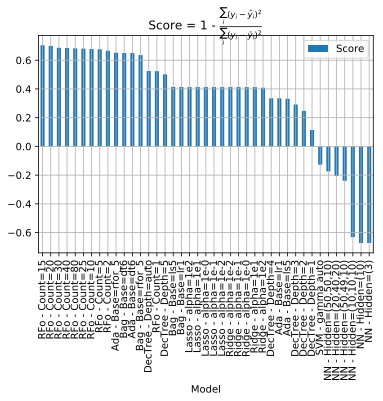

In [48]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
title = r"Score = 1 - $\frac{\sum_{i}(y_i - \hat{y}_i)^2}{\sum_{i}(y_i - \bar{y}_i)^2}$"
regression_result_barplot = classifier_results_df.plot.bar(x="Model", y="Score", \
                                                           grid=True, title=title)

In [49]:
fig = regression_result_barplot.get_figure()
fig.tight_layout()
fig.savefig("regression_result_barplot.png", dpi=500)

# Interpret the Random Forest Model

## Use ```feature_importances_```

In [75]:
rf_intp = {"Variable": X.columns, "Importance": rfor_5.feature_importances_}
rf_intp_df = pd.DataFrame.from_dict(rf_intp)
rf_intp_df = rf_intp_df.sort_values(by=["Importance"], axis=0, ascending=False)
rf_intp_df

,Importance,Variable
2,0.296378,popdens
14,0.290910,propoa
1,0.105100,Shape_Area
0,0.077690,Shape_Leng
15,0.042782,propnonw
8,0.024754,intdens
12,0.020975,ptrans
17,0.018679,BoroCode_1
16,0.017812,offpcap
13,0.016113,pwalk


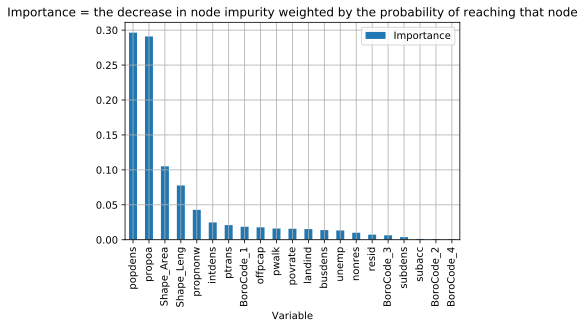

In [95]:
title = r"Importance = the decrease in node impurity weighted by the probability of reaching that node"
rf_intp_barplot = rf_intp_df.plot.bar(x="Variable", y="Importance", \
                                                           grid=True, title=title)

In [96]:
fig = rf_intp_barplot.get_figure()
fig.tight_layout()
fig.savefig("rf_intp_barplot.png", dpi=500)

## Use Scatter Plots

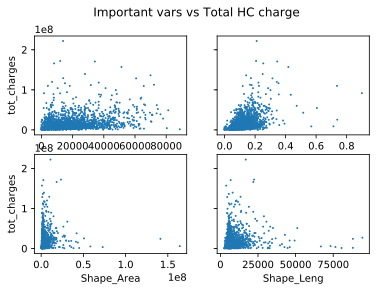

In [106]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, sharey="all")
raw_geo_data.plot.scatter(x="popdens", y="tot_charges", ax=axes[0, 0], s=1)
raw_geo_data.plot.scatter(x="propoa", y="tot_charges", ax=axes[0, 1], s=1)
raw_geo_data.plot.scatter(x="Shape_Area", y="tot_charges", ax=axes[1, 0], s=1)
raw_geo_data.plot.scatter(x="Shape_Leng", y="tot_charges", ax=axes[1, 1], s=1)
fig.suptitle("Important vars vs Total HC charge")

In [107]:
fig.tight_layout()
fig.savefig("visualization_with_scatter.png", dpi=500)

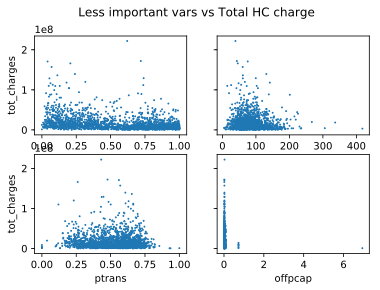

In [108]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey="all")
raw_geo_data.plot.scatter(x="propnonw", y="tot_charges", ax=axes[0, 0], s=1)
raw_geo_data.plot.scatter(x="intdens", y="tot_charges", ax=axes[0, 1], s=1)
raw_geo_data.plot.scatter(x="ptrans", y="tot_charges", ax=axes[1, 0], s=1)
raw_geo_data.plot.scatter(x="offpcap", y="tot_charges", ax=axes[1, 1], s=1)
fig.suptitle("Less important vars vs Total HC charge")

In [109]:
fig.tight_layout()
fig.savefig("visualization_with_scatter_2.png", dpi=500)

## Use ```treeinterpreter```

In [53]:
#!pip install treeinterpreter
from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [68]:
instances = X_test_std[:10]
prediction, bias, contributions = ti.predict(rfor_5, instances)

In [70]:
for i in range(len(instances)):
    print("Instance", i)
    print("Bias (trainset mean)", bias[i])
    print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], \
                                 X.columns), \
                             key=lambda x: -abs(x[0])):
        print(feature, round(c, 2))
    print("-"*20)

Instance 0
Bias (trainset mean) 15719994.584048774
Feature contributions:
propoa -9408700.32
popdens 5575020.16
povrate 1919899.85
Shape_Area -1676329.16
propnonw -934592.42
intdens 480727.63
Shape_Leng 444152.43
pwalk -423787.48
BoroCode_1 -383817.44
busdens -138204.81
offpcap -138069.52
ptrans -86229.36
nonres 83654.86
BoroCode_2 -81436.58
unemp 62499.4
subacc 47377.2
subdens 40659.92
landind -23628.37
resid 19660.3
BoroCode_3 0.0
BoroCode_4 0.0
--------------------
Instance 1
Bias (trainset mean) 15719994.584048774
Feature contributions:
propoa -5145682.23
offpcap 2794763.22
propnonw -1871111.67
popdens -1810538.92
Shape_Area -1503940.23
nonres -375286.92
ptrans 304081.78
BoroCode_1 -249603.39
resid 211973.86
pwalk 183852.45
unemp -173153.03
povrate 123749.44
subdens -57641.38
intdens 36600.0
landind -26711.15
BoroCode_2 15258.31
Shape_Leng -13602.34
busdens 6196.8
subacc 0.0
BoroCode_3 0.0
BoroCode_4 0.0
--------------------
Instance 2
Bias (trainset mean) 15719994.584048774
Featur

In [72]:
print(prediction)
print(y_test[:10])
print(bias + np.sum(contributions, axis=1))

[[11098850.876     ]
 [ 8169199.17466667]
 [11051637.71466667]
 [ 3672656.192     ]
 [32785885.46333333]
 [15836257.65      ]
 [23940972.506     ]
 [ 4190525.95533333]
 [44751784.296     ]
 [14993997.77666667]]
       tot_charges
1883  7.515828e+06
416   5.816003e+06
755   7.919168e+06
685   1.044038e+07
1747  1.198801e+08
1028  1.741268e+07
1905  2.166692e+07
1742  4.578660e+06
2193  5.129292e+07
1496  8.390857e+06
[11098850.876       8169199.17466667 11051637.71466667  3672656.192
 32785885.46333333 15836257.65       23940972.506       4190525.95533334
 44751784.296      14993997.77666667]
